<a href="https://colab.research.google.com/github/kanawanttotimetravel/AIT3001-final-project/blob/main/seq2seq_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtext==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.13.2 requires torch>=1.13.0, but you have torch 1.11.0 which is incompatible.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.20.1+cu121 requires torch==2.5.1, but you have torch 1.11.0 which is incompatible.


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
peft 0.13.2 requires torch>=1.13.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
import os
import time
import math
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
import yaml

**Phần 2: Cấu hình**

In [ ]:
# Tạo dictionary chứa cấu hình
CONF = {
    # Cấu hình cho dữ liệu
    'lower': True,
    'tokenizer': 'basic_english',
    'subword_tokenizer': 'bpe',
    'unk_token': '<unk>',
    'sos_token': '<s>',
    'eos_token': '</s>',
    'pad_token': '<pad>',
    'min_freq': 1,
    'src': 'en',
    'tgt': 'vi',
    'seed': 123,
    'epochs': 25,
    'max_length': 100,
    'clip': 0.2,
    'dropout': 0.1,
    'embed_size': 256,
    'hidden_size': 256,
    'batch_size': 256,
    'kernel_size': 3,
    'encoder_layers': 6,
    'decoder_layers': 6,
}

# Thêm token đặc biệt vào cấu hình
CONF["special_tokens"] = {
    CONF["unk_token"]: 0,
    CONF["pad_token"]: 1,
    CONF["sos_token"]: 2,
    CONF["eos_token"]: 3,
}

# Định nghĩa hàm load_tokenizer
from torchtext.data.utils import get_tokenizer

def load_tokenizer(name, lang=None):
    """
    Tải tokenizer dựa trên tên.
    Các tokenizer hỗ trợ: 'basic_english', 'spacy', v.v.
    """
    if name == "basic_english":
        return get_tokenizer("basic_english")
    elif name == "spacy":
        try:
            import spacy
            return spacy.load(lang).tokenizer
        except ImportError:
            raise ImportError("Spacy chưa được cài đặt. Hãy cài bằng lệnh '!pip install spacy'")
    else:
        raise ValueError(f"Tokenizer '{name}' không được hỗ trợ!")


**Phần 3: Thiết Lập Seed và Device**

In [ ]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Set the device (GPU or CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seed
set_seed(CONF['seed'])

# Display the device being used
print(f"Using device: {DEVICE}")


Using device: cuda


**Phần 4: Dataloader và TextTransform**

In [ ]:
from datasets import load_dataset
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn

def load_hf_dataset():
    """
    Tải bộ dữ liệu Anh - Việt từ Hugging Face.
    Trả về tập train, validation, và test.
    """

    dataset = load_dataset("harouzie/vi_en-translation")
    train_data = dataset['train']
    valid_data = dataset['valid']
    test_data = dataset['test']

    # Định dạng lại dữ liệu thành (src, tgt) cặp câu
    train_data = [(ex['English'], ex['Vietnamese']) for ex in train_data]
    valid_data = [(ex['English'], ex['Vietnamese']) for ex in valid_data]
    test_data = [(ex['English'], ex['Vietnamese']) for ex in test_data]

    return train_data, valid_data, test_data

# Hàm tạo vocab từ iterator
def get_vocab(train_iter, tokenizer, conf):
    special_tokens = conf["special_tokens"]
    unk_idx = special_tokens[conf["unk_token"]]
    vocab = build_vocab_from_iterator(
        map(tokenizer, train_iter),
        min_freq=conf["min_freq"],
        specials=list(special_tokens.keys())
    )
    vocab.set_default_index(unk_idx)
    return vocab

# Lớp TextTransform để chuyển đổi câu thành tensor
class TextTransform(nn.Module):
    def __init__(self, tokenizer, vocab, conf):
        super(TextTransform, self).__init__()
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.SOS_IDX = conf["special_tokens"][conf["sos_token"]]
        self.EOS_IDX = conf["special_tokens"][conf["eos_token"]]

    def forward(self, sentence):
        tokens = self.tokenizer(sentence)
        token_ids = self.vocab(tokens)
        return torch.cat((torch.tensor([self.SOS_IDX]), torch.tensor(token_ids), torch.tensor([self.EOS_IDX])))

# Hàm lấy DataLoader với transform cho dữ liệu nguồn và đích
def get_dataloader(data, src_transform, tgt_transform, conf):
    def collate_fn(batch):
        PAD_IDX = conf["special_tokens"][conf["pad_token"]]
        src_batch, tgt_batch = [], []
        for src_sample, tgt_sample in batch:
            src_batch.append(src_transform(src_sample.rstrip("\n")))
            tgt_batch.append(tgt_transform(tgt_sample.rstrip("\n")))
        # Chuyển src_batch và tgt_batch sang đúng thiết bị
        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True).to(DEVICE)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True).to(DEVICE)
        return src_batch, tgt_batch

    return DataLoader(data, batch_size=conf["batch_size"], collate_fn=collate_fn)

# Tải tokenizer
src_tokenizer = load_tokenizer(CONF['tokenizer'], CONF['src'])
tgt_tokenizer = load_tokenizer(CONF['tokenizer'], CONF['tgt'])

# Tải bộ dữ liệu từ Hugging Face và tạo vocab
train_data, valid_data, test_data = load_hf_dataset()
src_vocab = get_vocab((src for src, _ in train_data), src_tokenizer, CONF)
tgt_vocab = get_vocab((tgt for _, tgt in train_data), tgt_tokenizer, CONF)

# Tạo transform cho dữ liệu nguồn và đích
src_transform = TextTransform(src_tokenizer, src_vocab, CONF)
tgt_transform = TextTransform(tgt_tokenizer, tgt_vocab, CONF)

# Lấy DataLoader cho tập huấn luyện, kiểm thử, và đánh giá
train_dataloader = get_dataloader(train_data, src_transform, tgt_transform, CONF)
valid_dataloader = get_dataloader(valid_data, src_transform, tgt_transform, CONF)
test_dataloader = get_dataloader(test_data, src_transform, tgt_transform, CONF)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

(…)-00000-of-00001-8fc21cb8e80d3a2d.parquet:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

(…)-00000-of-00001-858c0e989d9c5637.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

(…)-00000-of-00001-99e7e50144d1c164.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

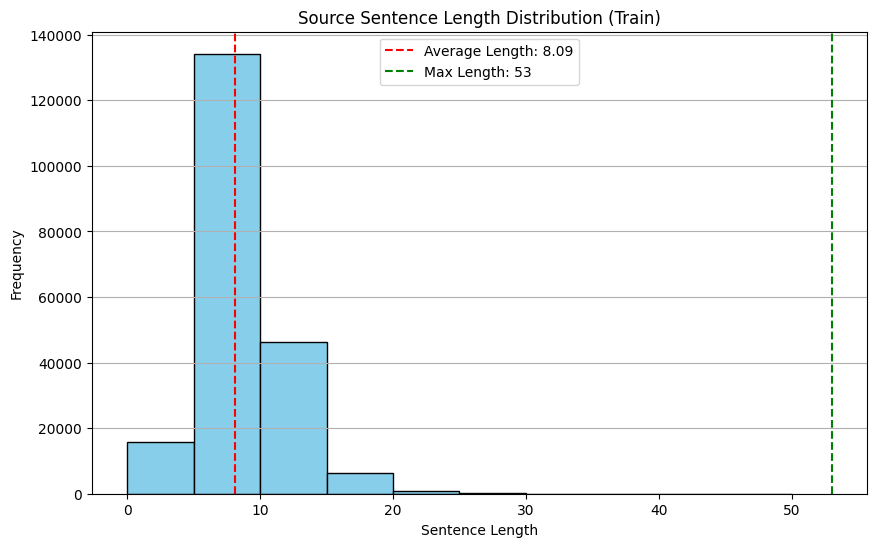

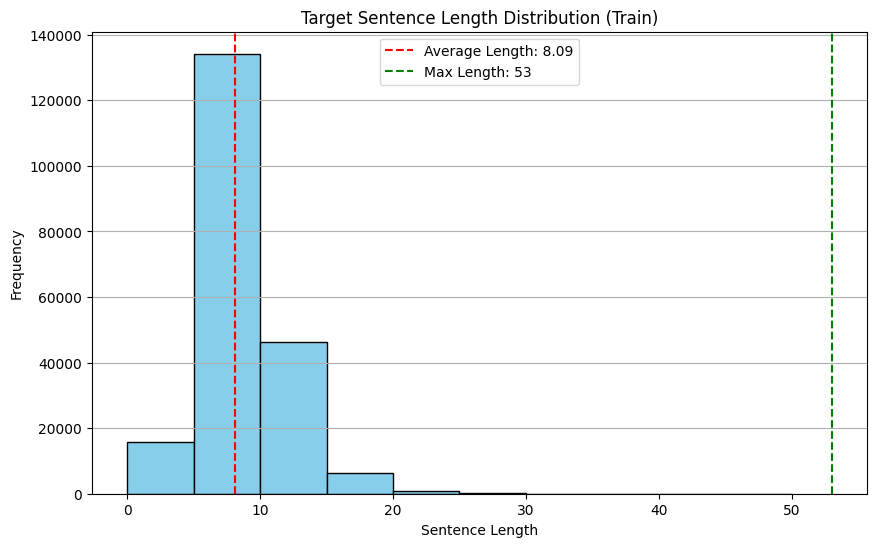

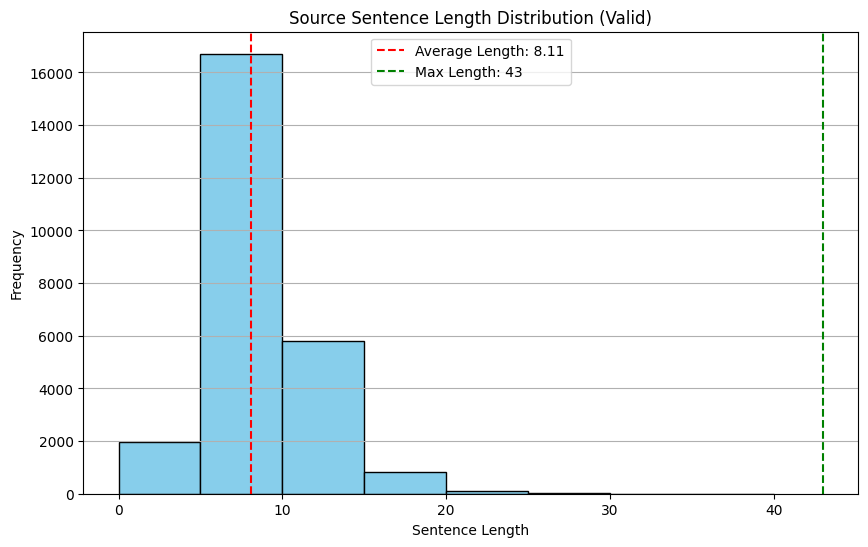

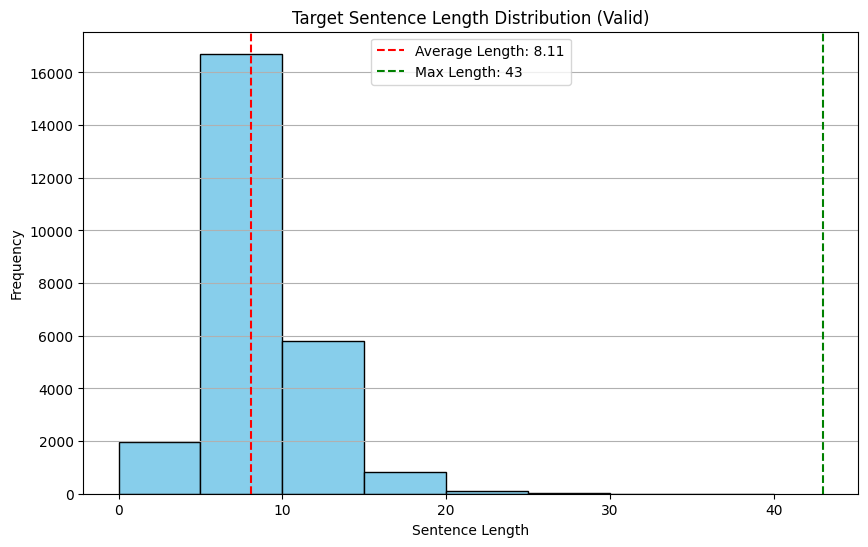

In [ ]:
import matplotlib.pyplot as plt

# Hàm tính toán và vẽ biểu đồ độ dài
def plot_length_statistics(data, tokenizer, title):
    """
    Vẽ biểu đồ phân phối độ dài, tính độ dài trung bình và lớn nhất.
    :param data: Dữ liệu đầu vào dưới dạng (src, tgt).
    :param tokenizer: Tokenizer được sử dụng để tách câu.
    :param title: Tiêu đề của biểu đồ.
    """
    lengths = [len(tokenizer(sentence)) for sentence, _ in data]

    # Tính các thống kê cơ bản
    avg_length = sum(lengths) / len(lengths)
    max_length = max(lengths)

    # Vẽ biểu đồ phân phối
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=range(0, max(lengths) + 1, 5), color='skyblue', edgecolor='black')
    plt.axvline(avg_length, color='red', linestyle='--', label=f'Average Length: {avg_length:.2f}')
    plt.axvline(max_length, color='green', linestyle='--', label=f'Max Length: {max_length}')
    plt.title(title)
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Vẽ biểu đồ cho tập huấn luyện
plot_length_statistics(train_data, src_tokenizer, "Source Sentence Length Distribution (Train)")
plot_length_statistics(train_data, tgt_tokenizer, "Target Sentence Length Distribution (Train)")

# Vẽ biểu đồ cho tập kiểm thử
plot_length_statistics(valid_data, src_tokenizer, "Source Sentence Length Distribution (Valid)")
plot_length_statistics(valid_data, tgt_tokenizer, "Target Sentence Length Distribution (Valid)")

**Phần 5: Xây Dựng Mô Hình**

In [ ]:
# Định nghĩa lớp Encoder
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, device, max_length):
        super(Encoder, self).__init__()

        assert kernel_size % 2 == 1, "Kernel size must be odd!"

        self.device = device

        self.scale = torch.FloatTensor([math.sqrt(0.5)]).to(device)

        self.tok_embedding = torch.nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = torch.nn.Embedding(max_length, emb_dim)

        self.emb2hid = torch.nn.Linear(emb_dim, hid_dim)
        self.hid2emb = torch.nn.Linear(hid_dim, emb_dim)

        self.convs = torch.nn.ModuleList([
            torch.nn.Conv1d(in_channels=hid_dim,
                            out_channels=2 * hid_dim,
                            kernel_size=kernel_size,
                            padding=(kernel_size - 1) // 2)
        for _ in range(n_layers)])
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, src):
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).repeat(batch_size, 1).to(self.device)

        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        embedded = self.dropout(tok_embedded + pos_embedded)

        conv_input = self.emb2hid(embedded)
        conv_input = conv_input.permute(0, 2, 1)

        for conv in self.convs:
            conved = conv(self.dropout(conv_input))
            conved = torch.nn.functional.glu(conved, dim=1)
            conved = (conved + conv_input) * self.scale
            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))
        combined = (conved + embedded) * self.scale
        return conved, combined


# Định nghĩa lớp Decoder
class Decoder(torch.nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, tgt_pad_idx, device, max_length):
        super(Decoder, self).__init__()

        self.kernel_size = kernel_size
        self.tgt_pad_idx = tgt_pad_idx
        self.device = device

        self.scale = torch.FloatTensor([math.sqrt(0.5)]).to(device)

        self.tok_embedding = torch.nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = torch.nn.Embedding(max_length, emb_dim)

        self.emb2hid = torch.nn.Linear(emb_dim, hid_dim)
        self.hid2emb = torch.nn.Linear(hid_dim, emb_dim)

        self.attn_hid2emb = torch.nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = torch.nn.Linear(emb_dim, hid_dim)

        self.fc_out = torch.nn.Linear(emb_dim, output_dim)

        self.convs = torch.nn.ModuleList([
            torch.nn.Conv1d(in_channels=hid_dim,
                            out_channels=2 * hid_dim,
                            kernel_size=kernel_size)
        for _ in range(n_layers)])

        self.dropout = torch.nn.Dropout(dropout)

    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        combined = (conved_emb + embedded) * self.scale
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        attention = torch.nn.functional.softmax(energy, dim=2)
        attended_encoding = torch.matmul(attention, encoder_combined)
        attended_encoding = self.attn_emb2hid(attended_encoding)
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        return attention, attended_combined

    def forward(self, tgt, encoder_conved, encoder_combined):
        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]
        pos = torch.arange(0, tgt_len).repeat(batch_size, 1).to(self.device)

        tok_embedded = self.tok_embedding(tgt)
        pos_embedded = self.pos_embedding(pos)
        embedded = self.dropout(tok_embedded + pos_embedded)

        conv_input = self.emb2hid(embedded)
        conv_input = conv_input.permute(0, 2, 1)

        for conv in self.convs:
            conv_input = self.dropout(conv_input)
            padding = torch.zeros(batch_size, conv_input.shape[1], self.kernel_size - 1).fill_(self.tgt_pad_idx).to(self.device)
            padded_conv_input = torch.cat((padding, conv_input), dim=2)
            conved = conv(padded_conv_input)
            conved = torch.nn.functional.glu(conved, dim=1)
            attention, conved = self.calculate_attention(embedded, conved, encoder_conved, encoder_combined)
            conved = (conved + conv_input) * self.scale
            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))
        output = self.fc_out(self.dropout(conved))
        return output, attention


# Định nghĩa mô hình Seq2Seq
class Seq2Seq(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt):
        encoder_conved, encoder_combined = self.encoder(src)
        output, attention = self.decoder(tgt, encoder_conved, encoder_combined)
        return output, attention


**Phần 6: Hàm Huấn Luyện và Đánh Giá**

In [ ]:
# Hàm huấn luyện cho một epoch
def train_epoch(model, data_loader, optimizer, criterion, clip, epoch):
    model.train()
    epoch_loss = 0
    for src, tgt in tqdm(data_loader, total=len(data_loader), desc=f"Training {epoch+1}"):
        # Chuyển dữ liệu sang đúng thiết bị
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        optimizer.zero_grad()
        output, _ = model(src, tgt[:, :-1])
        output_dim = output.shape[-1]

        # Làm phẳng output và target để tính loss
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)

        # Tính loss
        loss = criterion(output, tgt)
        loss.backward()

        # Gradient clipping để tránh gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Cập nhật trọng số
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

# Hàm đánh giá mô hình trên tập kiểm thử
def evaluate(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():  # Không tính toán gradient trong quá trình đánh giá
        for src, tgt in tqdm(data_loader, total=len(data_loader), desc="Evaluating"):
            # Chuyển dữ liệu sang đúng thiết bị
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            output, _ = model(src, tgt[:, :-1])
            output_dim = output.shape[-1]

            # Làm phẳng output và target để tính loss
            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)

            # Tính loss
            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

# Hàm huấn luyện mô hình qua nhiều epoch
def train(model, criterion, train_dataloader, valid_dataloader, optimizer, num_epochs, clip):
    train_losses = []  # Lưu train loss mỗi epoch
    val_losses = []    # Lưu validation loss mỗi epoch
    best_valid_loss = float('inf')  # Khởi tạo giá trị tốt nhất để lưu mô hình

    for epoch in range(num_epochs):
        start_time = time.time()

        # Huấn luyện mô hình trong một epoch
        train_loss = train_epoch(model, train_dataloader, optimizer, criterion, clip, epoch)
        train_losses.append(train_loss)  # Ghi lại train loss

        # Đánh giá mô hình sau một epoch
        valid_loss = evaluate(model, valid_dataloader, criterion)
        val_losses.append(valid_loss)  # Ghi lại validation loss

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Lưu mô hình nếu có validation loss tốt nhất
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            save_model(model)

        # In kết quả huấn luyện
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    return train_losses, val_losses  # Trả về danh sách train và validation loss

# Hàm lưu mô hình
def save_model(model, file_path="best_model.pt"):
    """
    Lưu trạng thái mô hình xuống file.
    """
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

**Phần 7: Thực Thi Huấn Luyện**

In [ ]:
# Hàm huấn luyện qua nhiều epoch
def train(model, criterion, train_dataloader, valid_dataloader, optimizer, num_epochs, clip):
    """
    Hàm huấn luyện và đánh giá mô hình qua nhiều epoch.
    """
    best_valid_loss = float('inf')  # Khởi tạo loss tốt nhất là vô cực
    train_losses = []  # Danh sách lưu train loss
    val_losses = []  # Danh sách lưu validation loss

    for epoch in range(num_epochs):
        start_time = time.time()  # Bắt đầu đo thời gian

        # Huấn luyện mô hình trong một epoch
        train_loss = train_epoch(model, train_dataloader, optimizer, criterion, clip, epoch)
        train_losses.append(train_loss)  # Lưu train loss

        # Đánh giá mô hình sau một epoch
        valid_loss = evaluate(model, valid_dataloader, criterion)
        val_losses.append(valid_loss)  # Lưu validation loss

        end_time = time.time()  # Kết thúc đo thời gian

        # Tính thời gian của epoch
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Lưu mô hình nếu có loss tốt nhất
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            save_model(model)

        # In kết quả của epoch
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    return train_losses, val_losses


def epoch_time(start_time, end_time):
    """
    Tính thời gian chạy của một epoch.
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs


def save_model(model, file_path="best_model.pt"):
    """
    Lưu trạng thái mô hình xuống file.
    """
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

# Chuyển encoder và decoder sang thiết bị
encoder = Encoder(
    input_dim=len(src_vocab),
    emb_dim=CONF['embed_size'],
    hid_dim=CONF['hidden_size'],
    n_layers=CONF['encoder_layers'],
    kernel_size=CONF['kernel_size'],
    dropout=CONF['dropout'],
    device=DEVICE,
    max_length=CONF['max_length'],
).to(DEVICE)

decoder = Decoder(
    output_dim=len(tgt_vocab),
    emb_dim=CONF['embed_size'],
    hid_dim=CONF['hidden_size'],
    n_layers=CONF['decoder_layers'],
    kernel_size=CONF['kernel_size'],
    dropout=CONF['dropout'],
    tgt_pad_idx=CONF["special_tokens"][CONF['pad_token']],
    device=DEVICE,
    max_length=CONF['max_length'],
).to(DEVICE)

# Khởi tạo mô hình Seq2Seq và chuyển sang thiết bị
model = Seq2Seq(encoder, decoder).to(DEVICE)

# In ra thiết bị để kiểm tra
print("Model is on device:", next(model.parameters()).device)

# Hàm tính số lượng tham số có thể huấn luyện của mô hình
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Sau đó, gọi hàm này để in số lượng tham số huấn luyện
trainable_params = count_trainable_params(model)
print(f"Trainable parameters: {trainable_params}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=CONF["special_tokens"][CONF['pad_token']])

clip = CONF["clip"]  # Lấy giá trị clip từ cấu hình
train_losses, val_losses = train(model, criterion, train_dataloader, valid_dataloader, optimizer, CONF["epochs"], clip)

# Lưu mô hình tốt nhất
save_model(model)


Model is on device: cuda:0
Trainable parameters: 13506254


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


Model saved to best_model.pt
Epoch: 01 | Time: 1m 57s
	Train Loss: 4.921 | Train PPL: 137.143
	 Val. Loss: 4.163 |  Val. PPL:  64.294


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


Model saved to best_model.pt
Epoch: 02 | Time: 1m 57s
	Train Loss: 3.714 | Train PPL:  41.028
	 Val. Loss: 3.087 |  Val. PPL:  21.901


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Model saved to best_model.pt
Epoch: 03 | Time: 1m 57s
	Train Loss: 3.004 | Train PPL:  20.176
	 Val. Loss: 2.568 |  Val. PPL:  13.035


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


Model saved to best_model.pt
Epoch: 04 | Time: 1m 58s
	Train Loss: 2.587 | Train PPL:  13.293
	 Val. Loss: 2.211 |  Val. PPL:   9.123


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


Model saved to best_model.pt
Epoch: 05 | Time: 1m 57s
	Train Loss: 2.284 | Train PPL:   9.814
	 Val. Loss: 1.954 |  Val. PPL:   7.056


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Model saved to best_model.pt
Epoch: 06 | Time: 1m 57s
	Train Loss: 2.057 | Train PPL:   7.826
	 Val. Loss: 1.767 |  Val. PPL:   5.856


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


Model saved to best_model.pt
Epoch: 07 | Time: 1m 57s
	Train Loss: 1.883 | Train PPL:   6.573
	 Val. Loss: 1.628 |  Val. PPL:   5.095


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


Model saved to best_model.pt
Epoch: 08 | Time: 1m 57s
	Train Loss: 1.745 | Train PPL:   5.727
	 Val. Loss: 1.515 |  Val. PPL:   4.549


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


Model saved to best_model.pt
Epoch: 09 | Time: 2m 0s
	Train Loss: 1.634 | Train PPL:   5.126
	 Val. Loss: 1.427 |  Val. PPL:   4.167


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


Model saved to best_model.pt
Epoch: 10 | Time: 1m 57s
	Train Loss: 1.541 | Train PPL:   4.667
	 Val. Loss: 1.357 |  Val. PPL:   3.885


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.95it/s]


Model saved to best_model.pt
Epoch: 11 | Time: 1m 57s
	Train Loss: 1.462 | Train PPL:   4.315
	 Val. Loss: 1.297 |  Val. PPL:   3.658


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


Model saved to best_model.pt
Epoch: 12 | Time: 1m 57s
	Train Loss: 1.394 | Train PPL:   4.032
	 Val. Loss: 1.246 |  Val. PPL:   3.478


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 16.72it/s]


Model saved to best_model.pt
Epoch: 13 | Time: 1m 57s
	Train Loss: 1.335 | Train PPL:   3.799
	 Val. Loss: 1.203 |  Val. PPL:   3.329


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


Model saved to best_model.pt
Epoch: 14 | Time: 1m 57s
	Train Loss: 1.281 | Train PPL:   3.602
	 Val. Loss: 1.163 |  Val. PPL:   3.199


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


Model saved to best_model.pt
Epoch: 15 | Time: 1m 57s
	Train Loss: 1.234 | Train PPL:   3.435
	 Val. Loss: 1.129 |  Val. PPL:   3.092


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.93it/s]


Model saved to best_model.pt
Epoch: 16 | Time: 1m 57s
	Train Loss: 1.190 | Train PPL:   3.288
	 Val. Loss: 1.097 |  Val. PPL:   2.997


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 16.96it/s]


Model saved to best_model.pt
Epoch: 17 | Time: 1m 57s
	Train Loss: 1.153 | Train PPL:   3.166
	 Val. Loss: 1.072 |  Val. PPL:   2.920


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.22it/s]


Model saved to best_model.pt
Epoch: 18 | Time: 1m 57s
	Train Loss: 1.118 | Train PPL:   3.058
	 Val. Loss: 1.047 |  Val. PPL:   2.849


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.85it/s]


Model saved to best_model.pt
Epoch: 19 | Time: 1m 57s
	Train Loss: 1.085 | Train PPL:   2.958
	 Val. Loss: 1.027 |  Val. PPL:   2.793


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.62it/s]


Model saved to best_model.pt
Epoch: 20 | Time: 1m 57s
	Train Loss: 1.055 | Train PPL:   2.871
	 Val. Loss: 1.004 |  Val. PPL:   2.730


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.85it/s]


Model saved to best_model.pt
Epoch: 21 | Time: 1m 57s
	Train Loss: 1.026 | Train PPL:   2.789
	 Val. Loss: 0.985 |  Val. PPL:   2.678


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Model saved to best_model.pt
Epoch: 22 | Time: 1m 57s
	Train Loss: 0.998 | Train PPL:   2.714
	 Val. Loss: 0.970 |  Val. PPL:   2.638


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.77it/s]


Model saved to best_model.pt
Epoch: 23 | Time: 1m 57s
	Train Loss: 0.975 | Train PPL:   2.652
	 Val. Loss: 0.955 |  Val. PPL:   2.598


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


Model saved to best_model.pt
Epoch: 24 | Time: 1m 57s
	Train Loss: 0.954 | Train PPL:   2.597
	 Val. Loss: 0.941 |  Val. PPL:   2.562


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


Model saved to best_model.pt
Epoch: 25 | Time: 1m 57s
	Train Loss: 0.932 | Train PPL:   2.539
	 Val. Loss: 0.926 |  Val. PPL:   2.524
Model saved to best_model.pt


**Phần 8: Lưu và Tải Mô Hình**

In [ ]:
# Hàm lưu mô hình
def save_model(model, path="bestmodel.pt"):
    """
    Lưu trạng thái của mô hình vào file.
    Args:
        model: Mô hình cần lưu.
        path: Đường dẫn file lưu trạng thái mô hình.
    """
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}!")

# Hàm tải mô hình đã lưu
def load_model(model, path="bestmodel.pt"):
    """
    Tải trạng thái mô hình từ file đã lưu.
    Args:
        model: Mô hình cần tải lại trạng thái.
        path: Đường dẫn file chứa trạng thái mô hình.
    Returns:
        model: Mô hình đã được tải trạng thái.
    """
    model.load_state_dict(torch.load(path))
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    print(f"Model loaded from {path}!")
    return model

# Lưu mô hình sau khi huấn luyện
save_model(model)

# Tải lại mô hình đã lưu
loaded_model = Seq2Seq(encoder, decoder).to(DEVICE)  # Khởi tạo lại mô hình
loaded_model = load_model(loaded_model)


Model saved to bestmodel.pt!
Model loaded from bestmodel.pt!


In [ ]:
import random

# Lấy 3 câu ngẫu nhiên từ dataloader
num_sentences_to_print = 3

# Chuyển dataloader thành danh sách để lấy ngẫu nhiên
test_samples = list(test_dataloader)
random_samples = random.sample(test_samples, num_sentences_to_print)

with torch.no_grad():
    for src, tgt in random_samples:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        output, _ = loaded_model(src, tgt[:, :-1])
        pred = output.argmax(-1)

        # Loại bỏ token <pad>, <unk>, <s>, </s>
        remove_tokens = {"<pad>", "<unk>", "<s>", "</s>"}
        src_sentence = " ".join([src_vocab.lookup_token(idx) for idx in src[0].tolist() if src_vocab.lookup_token(idx) not in remove_tokens])
        tgt_sentence = " ".join([tgt_vocab.lookup_token(idx) for idx in tgt[0].tolist() if tgt_vocab.lookup_token(idx) not in remove_tokens])
        pred_sentence = " ".join([tgt_vocab.lookup_token(idx) for idx in pred[0].tolist() if tgt_vocab.lookup_token(idx) not in remove_tokens])

        # Hiển thị kết quả
        print(f"Source: {src_sentence}")
        print(f"Target: {tgt_sentence}")
        print(f"Prediction: {pred_sentence}")
        print("-" * 50)


Source: is anything up ?
Target: có chuyện gì thế
Prediction: có gì gì không không ? ? ? ? ? ? ? ? ? ? ? ? ? ?
--------------------------------------------------
Source: it might be expensive .
Target: nó có thể đắt
Prediction: nó có thể đắt . . . . . . . . . . . . . . .
--------------------------------------------------
Source: what i did was wrong .
Target: những gì tôi đã làm là sai .
Prediction: những gì tôi đã làm là sai . . . . . . . . . . . . .
--------------------------------------------------


**Phần 9: Bleu Bleu Bleu**

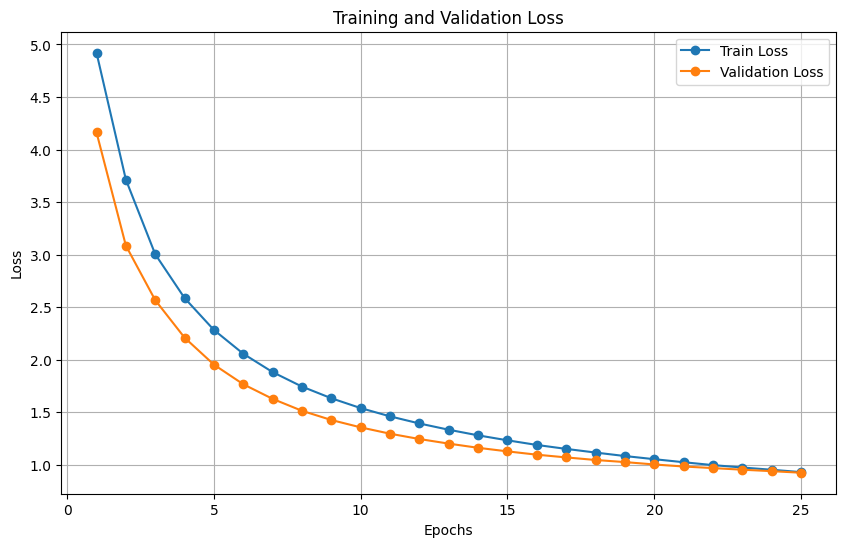

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train_losses, val_losses)


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
import torch.nn.functional as F

def calculate_bleu_and_loss(model, dataloader, src_vocab, tgt_vocab, loss_fn, output_file="evaluation_results.txt"):
    model.eval()
    total_bleu = 0
    total_loss = 0
    num_samples = 0
    smooth_fn = SmoothingFunction().method1
    results = []

    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            # Forward pass
            output, _ = model(src, tgt[:, :-1])  # tgt[:, :-1] excludes the last token (</s>)
            pred = output.argmax(-1)

            # Calculate loss
            loss = loss_fn(output.view(-1, output.size(-1)), tgt[:, 1:].contiguous().view(-1))  # tgt[:, 1:] excludes the <s> token
            total_loss += loss.item()

            # Convert tensors to sentences
            pred_sentences = [
                [tgt_vocab.lookup_token(idx) for idx in pred[i].tolist() if tgt_vocab.lookup_token(idx) not in {"<pad>", "<s>", "</s>", "<unk>"}]
                for i in range(pred.size(0))
            ]
            tgt_sentences = [
                [tgt_vocab.lookup_token(idx) for idx in tgt[i].tolist() if tgt_vocab.lookup_token(idx) not in {"<pad>", "<s>", "</s>", "<unk>"}]
                for i in range(tgt.size(0))
            ]
            src_sentences = [
                [src_vocab.lookup_token(idx) for idx in src[i].tolist() if src_vocab.lookup_token(idx) not in {"<pad>", "<s>", "</s>", "<unk>"}]
                for i in range(src.size(0))
            ]

            # Calculate BLEU score for each sentence
            for src_sentence, pred_sentence, tgt_sentence in zip(src_sentences, pred_sentences, tgt_sentences):
                bleu = sentence_bleu([tgt_sentence], pred_sentence, smoothing_function=smooth_fn)
                total_bleu += bleu
                num_samples += 1

                # Record results
                results.append({
                    "Source": " ".join(src_sentence),
                    "Target": " ".join(tgt_sentence),
                    "Prediction": " ".join(pred_sentence),
                    "BLEU": bleu
                })

    # Write results to file
    with open(output_file, "w", encoding="utf-8") as f:
        for result in results:
            f.write(f"Source: {result['Source']}\n")
            f.write(f"Target: {result['Target']}\n")
            f.write(f"Prediction: {result['Prediction']}\n")
            f.write(f"BLEU Score: {result['BLEU']:.4f}\n")
            f.write("="*50 + "\n")

    avg_bleu = total_bleu / num_samples if num_samples > 0 else 0
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else 0
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Details saved to {output_file}!")

    return avg_bleu, avg_loss

# Example usage
loss_function = torch.nn.CrossEntropyLoss(ignore_index=src_vocab["<pad>"])
bleu_score, avg_loss = calculate_bleu_and_loss(loaded_model, test_dataloader, src_vocab, tgt_vocab, loss_function)


Average BLEU Score: 0.3479
Average Loss: 0.9150
Details saved to evaluation_results.txt!
